# Implementación del modelo base

### José Daniel Gómez Cabrera 21429

- Entrenar un modelo inicial con LightGBM utilizando métricas tradicionales como AUC-ROC y F1-score.
- Evaluar el rendimiento inicial en términos de fraude detectado y falsos positivos.


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

In [18]:
df = pd.read_csv('../data/dataset_feature_engineering.csv', header=0)

In [19]:
df.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,...,first_time_at_merchant,dist_between_client_and_merch,trans_month,trans_day,hour,year,times_shopped_at_merchant,times_shopped_at_merchant_year,times_shopped_at_merchant_month,times_shopped_at_merchant_day
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,...,True,78.773821,1,1,0,2019,5,4,2,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,...,True,30.216618,1,1,0,2019,4,4,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,...,True,108.102912,1,1,0,2019,4,3,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,...,True,95.685115,1,1,0,2019,1,1,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,...,True,77.702395,1,1,0,2019,6,1,1,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cc_num                           int64  
 1   merchant                         object 
 2   category                         object 
 3   amt                              float64
 4   first                            object 
 5   last                             object 
 6   gender                           object 
 7   street                           object 
 8   city                             object 
 9   state                            object 
 10  zip                              int64  
 11  lat                              float64
 12  long                             float64
 13  city_pop                         int64  
 14  job                              object 
 15  dob                              object 
 16  trans_num                        object 
 17  unix_tim

## Años y meses disponibles


In [21]:
print("Años disponibles:", df['year'].unique())
print("Meses disponibles:", df['trans_month'].unique())

Años disponibles: [2019 2020]
Meses disponibles: [ 1  2  3  4  5  6  7  8  9 10 11 12]


## Variable objetivo


In [22]:
fraud_dist = df['is_fraud'].value_counts().rename({0: 'No fraud', 1: 'Fraud'})
fraud_percent = (fraud_dist / fraud_dist.sum()) * 100

fraud_df = pd.DataFrame({
    'Amount': fraud_dist,
    'Percentage': fraud_percent.round(2)
})
fraud_df

,Amount,Percentage
is_fraud,,
No fraud,1842743,99.48
Fraud,9651,0.52


## Modelo 6


In [23]:
# Modelo 6 - Optimizado para maximizar el monto salvado en fraudes
# Este modelo utiliza LightGBM con una métrica personalizada que considera el monto de las transacciones

# Importamos las bibliotecas necesarias
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Definimos una métrica personalizada que considera el monto de las transacciones
def amount_saved_metric(y_true, y_pred, amounts):
    """
    Calcula el monto total salvado basado en detecciones correctas de fraude
    y penaliza los falsos positivos que podrían afectar la experiencia del cliente
    
    Args:
        y_true: Etiquetas reales
        y_pred: Predicciones (probabilidades)
        amounts: Montos de las transacciones
    """
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Verdaderos positivos (fraudes detectados correctamente)
    tp_mask = (y_true == 1) & (y_pred_binary == 1)
    amount_saved = amounts[tp_mask].sum()
    
    # Falsos positivos (transacciones legítimas marcadas como fraude)
    fp_mask = (y_true == 0) & (y_pred_binary == 1)
    false_positive_penalty = amounts[fp_mask].sum() * 0.1  # Penalización del 10% por falsos positivos
    
    return amount_saved - false_positive_penalty

# NUEVO: Cargamos y preparamos el dataset si aún no está cargado
# Nota: Este código asume que df ya está cargado en memoria
# Si no está cargado, descomentar lo siguiente y ajustar la ruta del archivo
# df = pd.read_csv('ruta_a_tu_archivo.csv')

# Preparación de datos
# Mantenemos la columna 'amt' para nuestra métrica personalizada
X = df.drop(['is_fraud', 'cc_num', 'merchant', 'category', 'first', 'last', 'gender', 
             'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num', 'unix_time'], axis=1)
y = df['is_fraud']

# NUEVO: Realizamos undersampling aleatorio antes de la división de datos
# El objetivo es reducir los falsos positivos equilibrando mejor las clases
print("Distribución original de clases:")
print(y.value_counts())

# NUEVO: Implementación manual del undersampling aleatorio
# Separamos los índices de cada clase
fraud_indices = df[df['is_fraud'] == 1].index
non_fraud_indices = df[df['is_fraud'] == 0].index

# Determinamos cuántas muestras de no fraude retener
# Usamos una proporción que reduzca significativamente los datos de la clase mayoritaria
sampling_ratio = 10  # Por cada fraude, cuántos no-fraudes mantenemos (ajustable)
n_non_fraud_to_keep = min(len(fraud_indices) * sampling_ratio, len(non_fraud_indices))

# Seleccionamos aleatoriamente muestras de la clase mayoritaria
np.random.seed(42)  # Para reproducibilidad
selected_non_fraud_indices = np.random.choice(non_fraud_indices, size=int(n_non_fraud_to_keep), replace=False)

# Combinamos los índices de fraude con los no fraude seleccionados
resampled_indices = np.concatenate([fraud_indices, selected_non_fraud_indices])
np.random.shuffle(resampled_indices)  # Mezclamos los índices

# Filtramos los datos usando los índices obtenidos del undersampling
X_resampled = X.iloc[resampled_indices]
y_resampled = y.iloc[resampled_indices]

print("Distribución de clases después del undersampling:")
print(y_resampled.value_counts())

# División de datos usando los datos con undersampling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Guardamos los montos para nuestra métrica
train_amounts = X_train['amt'].values
test_amounts = X_test['amt'].values

# Optimización de hiperparámetros usando Optuna
import optuna

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        # NUEVO: Reducimos el rango de scale_pos_weight ya que el conjunto está más balanceado
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
    }
    
    # Entrenamiento con validación temprana
    train_data = lgb.Dataset(X_train, y_train)
    valid_data = lgb.Dataset(X_test, y_test)
    
    model = lgb.train(params,
                     train_data,
                     num_boost_round=1000,
                     valid_sets=[valid_data],
                     callbacks=[lgb.early_stopping(stopping_rounds=20)])
    
    # Predicciones
    y_pred = model.predict(X_test)
    
    # Calculamos nuestra métrica personalizada
    amount_saved = amount_saved_metric(y_test, y_pred, test_amounts)
    
    return amount_saved

# Ejecutamos la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Entrenamos el modelo final con los mejores parámetros
best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt'
})

# Entrenamiento del modelo final
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_test, y_test)

final_model = lgb.train(best_params,
                       train_data,
                       num_boost_round=1000,
                       valid_sets=[valid_data],
                       callbacks=[lgb.early_stopping(stopping_rounds=20)])

# NUEVO: Evaluación en dos etapas
# 1. Primero evaluamos con el conjunto de prueba con undersampling
y_pred_proba = final_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nMétricas en conjunto de prueba con undersampling:")
print(classification_report(y_test, y_pred))

# Calculamos el monto total salvado
amount_saved = amount_saved_metric(y_test, y_pred_proba, test_amounts)
print(f"\nMonto total salvado en fraudes (conjunto balanceado): ${amount_saved:,.2f}")

# NUEVO: También validamos en un conjunto de datos original para evaluar el rendimiento real
# Creamos un conjunto de validación a partir de los datos originales
X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X, y, test_size=0.2, random_state=43)  # Diferente random_state para tener datos distintos

# Predecimos en el conjunto de datos original
y_orig_pred_proba = final_model.predict(X_orig_test)
y_orig_pred = (y_orig_pred_proba > 0.5).astype(int)

print("\nMétricas en conjunto de prueba original (sin undersampling):")
print(classification_report(y_orig_test, y_orig_pred))

# Calculamos el monto total salvado en el conjunto original
orig_test_amounts = X_orig_test['amt'].values
amount_saved_orig = amount_saved_metric(y_orig_test, y_orig_pred_proba, orig_test_amounts)
print(f"\nMonto total salvado en fraudes (conjunto original): ${amount_saved_orig:,.2f}")

# NUEVO: Ajuste del umbral de decisión para reducir aún más los falsos positivos
# Probamos diferentes umbrales para minimizar los falsos positivos
thresholds = np.arange(0.5, 0.95, 0.05)
best_threshold = 0.5
best_fp = float('inf')

print("\nBúsqueda del umbral óptimo para minimizar falsos positivos:")
for threshold in thresholds:
    y_pred_threshold = (y_orig_pred_proba > threshold).astype(int)
    fp_mask = (y_orig_test == 0) & (y_pred_threshold == 1)
    fp_count = np.sum(fp_mask)
    tp_mask = (y_orig_test == 1) & (y_pred_threshold == 1)
    tp_count = np.sum(tp_mask)
    
    print(f"Umbral: {threshold:.2f}, Falsos Positivos: {fp_count}, Verdaderos Positivos: {tp_count}")
    
    if fp_count < best_fp and tp_count > 0:
        best_fp = fp_count
        best_threshold = threshold

print(f"\nMejor umbral para reducir falsos positivos: {best_threshold:.2f}")

# Aplicamos el mejor umbral
y_final_pred = (y_orig_pred_proba > best_threshold).astype(int)

print("\nMétricas finales con umbral optimizado:")
print(classification_report(y_orig_test, y_final_pred))

# Análisis final de montos por tipo de predicción
tp_mask = (y_orig_test == 1) & (y_final_pred == 1)
fp_mask = (y_orig_test == 0) & (y_final_pred == 1)
fn_mask = (y_orig_test == 1) & (y_final_pred == 0)

print("\nAnálisis de montos con umbral optimizado:")
print(f"Monto promedio de fraudes detectados: ${orig_test_amounts[tp_mask].mean():,.2f}")
print(f"Monto promedio de falsos positivos: ${orig_test_amounts[fp_mask].mean():,.2f}" if np.sum(fp_mask) > 0 else "No hay falsos positivos")
print(f"Monto promedio de fraudes no detectados: ${orig_test_amounts[fn_mask].mean():,.2f}")
print(f"Número de falsos positivos: {np.sum(fp_mask)}")

# Calculamos el monto total salvado con el umbral optimizado
amount_saved_final = amount_saved_metric(y_orig_test, y_final_pred, orig_test_amounts)
print(f"\nMonto total salvado en fraudes (umbral optimizado): ${amount_saved_final:,.2f}")

Distribución original de clases:
is_fraud
0    1842743
1       9651
Name: count, dtype: int64


[I 2025-05-19 18:21:31,129] A new study created in memory with name: no-name-0bf9271b-b3d6-4d26-b7e1-50a5f323d4bf


Distribución de clases después del undersampling:
is_fraud
0    96510
1     9651
Name: count, dtype: int64
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:21:31,675] Trial 0 finished with value: 0.0 and parameters: {'num_leaves': 58, 'learning_rate': 0.014316154480888963, 'feature_fraction': 0.7587990623786502, 'min_child_samples': 17, 'scale_pos_weight': 3.6230550486496953}. Best is trial 0 with value: 0.0.


Early stopping, best iteration is:
[26]	valid_0's auc: 0.989743
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:21:32,456] Trial 1 finished with value: 0.0 and parameters: {'num_leaves': 94, 'learning_rate': 0.015057719892514658, 'feature_fraction': 0.6845867467717349, 'min_child_samples': 98, 'scale_pos_weight': 1.6812295433898279}. Best is trial 0 with value: 0.0.


Early stopping, best iteration is:
[31]	valid_0's auc: 0.990201
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:21:35,028] Trial 2 finished with value: 976456.3990000001 and parameters: {'num_leaves': 43, 'learning_rate': 0.08870627093386041, 'feature_fraction': 0.8473422706180707, 'min_child_samples': 98, 'scale_pos_weight': 1.2797369725649315}. Best is trial 2 with value: 976456.3990000001.


Early stopping, best iteration is:
[316]	valid_0's auc: 0.995501
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:21:41,228] Trial 3 finished with value: 980754.304 and parameters: {'num_leaves': 31, 'learning_rate': 0.01280652470503503, 'feature_fraction': 0.6447508371482223, 'min_child_samples': 54, 'scale_pos_weight': 1.6792009504534522}. Best is trial 3 with value: 980754.304.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.994436


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:21:46,816] Trial 4 finished with value: 991951.159 and parameters: {'num_leaves': 30, 'learning_rate': 0.03392949310753912, 'feature_fraction': 0.840264514090404, 'min_child_samples': 74, 'scale_pos_weight': 9.533861384502364}. Best is trial 4 with value: 991951.159.


Did not meet early stopping. Best iteration is:
[987]	valid_0's auc: 0.995276
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:21:53,456] Trial 5 finished with value: 990487.836 and parameters: {'num_leaves': 44, 'learning_rate': 0.03607960066238816, 'feature_fraction': 0.7972698874931827, 'min_child_samples': 29, 'scale_pos_weight': 6.278007768090031}. Best is trial 4 with value: 991951.159.


Early stopping, best iteration is:
[835]	valid_0's auc: 0.995718
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:21:57,420] Trial 6 finished with value: 991959.431 and parameters: {'num_leaves': 40, 'learning_rate': 0.05106887828166763, 'feature_fraction': 0.7177799737241368, 'min_child_samples': 35, 'scale_pos_weight': 6.716335938960064}. Best is trial 6 with value: 991959.431.


Early stopping, best iteration is:
[528]	valid_0's auc: 0.995487
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:22:00,666] Trial 7 finished with value: 991760.12 and parameters: {'num_leaves': 38, 'learning_rate': 0.06342592654264566, 'feature_fraction': 0.9146233588548297, 'min_child_samples': 64, 'scale_pos_weight': 9.59889580027793}. Best is trial 6 with value: 991959.431.


Early stopping, best iteration is:
[464]	valid_0's auc: 0.995145
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:22:04,979] Trial 8 finished with value: 991285.162 and parameters: {'num_leaves': 44, 'learning_rate': 0.06738965740759532, 'feature_fraction': 0.9733011004345634, 'min_child_samples': 87, 'scale_pos_weight': 9.006576208057593}. Best is trial 6 with value: 991959.431.


Early stopping, best iteration is:
[555]	valid_0's auc: 0.995321
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:22:09,776] Trial 9 finished with value: 990041.716 and parameters: {'num_leaves': 25, 'learning_rate': 0.02816379210551385, 'feature_fraction': 0.8270852854380131, 'min_child_samples': 16, 'scale_pos_weight': 3.8177797157822053}. Best is trial 6 with value: 991959.431.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.995033
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:22:15,759] Trial 10 finished with value: 989522.784 and parameters: {'num_leaves': 82, 'learning_rate': 0.04768986875906128, 'feature_fraction': 0.7107394560343804, 'min_child_samples': 43, 'scale_pos_weight': 6.860195088738784}. Best is trial 6 with value: 991959.431.


Early stopping, best iteration is:
[437]	valid_0's auc: 0.995847
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:22:20,294] Trial 11 finished with value: 990832.6410000001 and parameters: {'num_leaves': 21, 'learning_rate': 0.024632688685780894, 'feature_fraction': 0.615794282619986, 'min_child_samples': 69, 'scale_pos_weight': 7.962749453384578}. Best is trial 6 with value: 991959.431.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.994636
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:22:27,220] Trial 12 finished with value: 990314.272 and parameters: {'num_leaves': 60, 'learning_rate': 0.041758487168878616, 'feature_fraction': 0.8928906427041532, 'min_child_samples': 41, 'scale_pos_weight': 7.929657612898366}. Best is trial 6 with value: 991959.431.


Early stopping, best iteration is:
[679]	valid_0's auc: 0.99581
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:22:36,039] Trial 13 finished with value: 990006.4409999999 and parameters: {'num_leaves': 52, 'learning_rate': 0.021421512769781048, 'feature_fraction': 0.7484293702547352, 'min_child_samples': 76, 'scale_pos_weight': 4.931076040927097}. Best is trial 6 with value: 991959.431.


Did not meet early stopping. Best iteration is:
[998]	valid_0's auc: 0.995611


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:22:39,825] Trial 14 finished with value: 991904.4249999999 and parameters: {'num_leaves': 32, 'learning_rate': 0.05325519779701018, 'feature_fraction': 0.7755723695103365, 'min_child_samples': 49, 'scale_pos_weight': 9.950340088198137}. Best is trial 6 with value: 991959.431.


Early stopping, best iteration is:
[596]	valid_0's auc: 0.995103
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:22:43,268] Trial 15 finished with value: 988095.3439999999 and parameters: {'num_leaves': 74, 'learning_rate': 0.09016815176505771, 'feature_fraction': 0.8769350610658773, 'min_child_samples': 32, 'scale_pos_weight': 8.128145922926194}. Best is trial 6 with value: 991959.431.


Early stopping, best iteration is:
[265]	valid_0's auc: 0.995542
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


Early stopping, best iteration is:
[814]	valid_0's auc: 0.995499


[I 2025-05-19 18:22:52,977] Trial 16 finished with value: 990352.4469999999 and parameters: {'num_leaves': 72, 'learning_rate': 0.020614816426790344, 'feature_fraction': 0.7110918167746342, 'min_child_samples': 81, 'scale_pos_weight': 5.4107767669370865}. Best is trial 6 with value: 991959.431.
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:22:57,336] Trial 17 finished with value: 990922.1889999999 and parameters: {'num_leaves': 32, 'learning_rate': 0.03356480019473541, 'feature_fraction': 0.9538916009692562, 'min_child_samples': 61, 'scale_pos_weight': 6.736304945474247}. Best is trial 6 with value: 991959.431.


Early stopping, best iteration is:
[718]	valid_0's auc: 0.99495
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:01,767] Trial 18 finished with value: 992352.9160000001 and parameters: {'num_leaves': 55, 'learning_rate': 0.06183203553018986, 'feature_fraction': 0.8349376311773334, 'min_child_samples': 31, 'scale_pos_weight': 8.758452967826077}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[464]	valid_0's auc: 0.995634
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:06,688] Trial 19 finished with value: 990390.742 and parameters: {'num_leaves': 51, 'learning_rate': 0.06706772505335376, 'feature_fraction': 0.6765328501079221, 'min_child_samples': 28, 'scale_pos_weight': 8.625711459790303}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[530]	valid_0's auc: 0.996024
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:11,925] Trial 20 finished with value: 991315.2890000001 and parameters: {'num_leaves': 66, 'learning_rate': 0.051780587513204766, 'feature_fraction': 0.7357114743474817, 'min_child_samples': 38, 'scale_pos_weight': 7.233651863285825}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[464]	valid_0's auc: 0.995841
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:18,215] Trial 21 finished with value: 991874.618 and parameters: {'num_leaves': 53, 'learning_rate': 0.039111924412580594, 'feature_fraction': 0.8467132748136619, 'min_child_samples': 11, 'scale_pos_weight': 9.02853815380244}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[692]	valid_0's auc: 0.995628
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:21,166] Trial 22 finished with value: 991955.948 and parameters: {'num_leaves': 37, 'learning_rate': 0.07515709691580473, 'feature_fraction': 0.7926244802716814, 'min_child_samples': 25, 'scale_pos_weight': 7.536265386859215}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[423]	valid_0's auc: 0.995294
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:24,951] Trial 23 finished with value: 991365.669 and parameters: {'num_leaves': 39, 'learning_rate': 0.07673476164930505, 'feature_fraction': 0.7940071031119171, 'min_child_samples': 23, 'scale_pos_weight': 6.022369609454188}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[523]	valid_0's auc: 0.995617
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:28,088] Trial 24 finished with value: 991775.143 and parameters: {'num_leaves': 49, 'learning_rate': 0.058060662065832644, 'feature_fraction': 0.8115069435821288, 'min_child_samples': 23, 'scale_pos_weight': 7.544871447961355}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[351]	valid_0's auc: 0.995325
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:31,610] Trial 25 finished with value: 989933.8090000001 and parameters: {'num_leaves': 66, 'learning_rate': 0.09909397292414461, 'feature_fraction': 0.9226168112014168, 'min_child_samples': 35, 'scale_pos_weight': 4.784241847724787}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[305]	valid_0's auc: 0.995516
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:34,521] Trial 26 finished with value: 990981.8790000002 and parameters: {'num_leaves': 37, 'learning_rate': 0.07770534983551917, 'feature_fraction': 0.7767487079187787, 'min_child_samples': 50, 'scale_pos_weight': 6.364638249701483}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[421]	valid_0's auc: 0.99531
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:36,841] Trial 27 finished with value: 992143.675 and parameters: {'num_leaves': 20, 'learning_rate': 0.04428792226690495, 'feature_fraction': 0.7149094695780938, 'min_child_samples': 44, 'scale_pos_weight': 8.35979914905689}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[532]	valid_0's auc: 0.99438
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:40,360] Trial 28 finished with value: 992274.769 and parameters: {'num_leaves': 21, 'learning_rate': 0.04405922861682074, 'feature_fraction': 0.6007281887952217, 'min_child_samples': 47, 'scale_pos_weight': 8.485632156771654}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[754]	valid_0's auc: 0.994825
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:42,722] Trial 29 finished with value: 990636.386 and parameters: {'num_leaves': 20, 'learning_rate': 0.04157448442192338, 'feature_fraction': 0.6029467999048863, 'min_child_samples': 44, 'scale_pos_weight': 8.597929245195296}. Best is trial 18 with value: 992352.9160000001.


Early stopping, best iteration is:
[509]	valid_0's auc: 0.994237
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:45,850] Trial 30 finished with value: 992393.052 and parameters: {'num_leaves': 27, 'learning_rate': 0.045291024956240364, 'feature_fraction': 0.6408292070016339, 'min_child_samples': 59, 'scale_pos_weight': 8.851916921024916}. Best is trial 30 with value: 992393.052.


Early stopping, best iteration is:
[580]	valid_0's auc: 0.994938
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:49,738] Trial 31 finished with value: 992056.5810000001 and parameters: {'num_leaves': 23, 'learning_rate': 0.04622862786723566, 'feature_fraction': 0.6391851389206571, 'min_child_samples': 58, 'scale_pos_weight': 8.635585496632258}. Best is trial 30 with value: 992393.052.


Early stopping, best iteration is:
[840]	valid_0's auc: 0.995166
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:23:59,459] Trial 32 finished with value: 991477.3350000001 and parameters: {'num_leaves': 99, 'learning_rate': 0.029253947340401792, 'feature_fraction': 0.6715955175018974, 'min_child_samples': 48, 'scale_pos_weight': 9.172543390637145}. Best is trial 30 with value: 992393.052.


Early stopping, best iteration is:
[598]	valid_0's auc: 0.995801


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:24:02,235] Trial 33 finished with value: 991523.793 and parameters: {'num_leaves': 24, 'learning_rate': 0.05778216720204698, 'feature_fraction': 0.6409960946273907, 'min_child_samples': 54, 'scale_pos_weight': 8.218293072236868}. Best is trial 30 with value: 992393.052.


Early stopping, best iteration is:
[569]	valid_0's auc: 0.995138
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:24:05,989] Trial 34 finished with value: 992392.5539999999 and parameters: {'num_leaves': 27, 'learning_rate': 0.04410694550536231, 'feature_fraction': 0.6218538190855217, 'min_child_samples': 67, 'scale_pos_weight': 9.870437062773654}. Best is trial 30 with value: 992393.052.


Early stopping, best iteration is:
[658]	valid_0's auc: 0.994987
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:24:10,516] Trial 35 finished with value: 993839.679 and parameters: {'num_leaves': 28, 'learning_rate': 0.037749440969221844, 'feature_fraction': 0.6178676160817642, 'min_child_samples': 66, 'scale_pos_weight': 9.999790714253207}. Best is trial 35 with value: 993839.679.


Early stopping, best iteration is:
[786]	valid_0's auc: 0.995035
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:24:16,068] Trial 36 finished with value: 993230.8949999999 and parameters: {'num_leaves': 28, 'learning_rate': 0.014825260562987653, 'feature_fraction': 0.6574459549198638, 'min_child_samples': 67, 'scale_pos_weight': 9.743600258386978}. Best is trial 35 with value: 993839.679.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.994372


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:24:16,501] Trial 37 finished with value: 0.0 and parameters: {'num_leaves': 30, 'learning_rate': 0.010055725666910981, 'feature_fraction': 0.6509017293426786, 'min_child_samples': 67, 'scale_pos_weight': 9.897722300033031}. Best is trial 35 with value: 993839.679.


Early stopping, best iteration is:
[43]	valid_0's auc: 0.988501
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:24:16,888] Trial 38 finished with value: 222868.84900000002 and parameters: {'num_leaves': 27, 'learning_rate': 0.013676452903846725, 'feature_fraction': 0.6278809465320236, 'min_child_samples': 88, 'scale_pos_weight': 9.454049113136582}. Best is trial 35 with value: 993839.679.


Early stopping, best iteration is:
[43]	valid_0's auc: 0.988315
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:24:22,300] Trial 39 finished with value: 987515.5560000001 and parameters: {'num_leaves': 28, 'learning_rate': 0.015979077065308926, 'feature_fraction': 0.6593465646164498, 'min_child_samples': 72, 'scale_pos_weight': 2.8322149885833343}. Best is trial 35 with value: 993839.679.


Did not meet early stopping. Best iteration is:
[993]	valid_0's auc: 0.994669
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:24:27,204] Trial 40 finished with value: 993258.8389999999 and parameters: {'num_leaves': 35, 'learning_rate': 0.0368480248362926, 'feature_fraction': 0.6923644733486394, 'min_child_samples': 63, 'scale_pos_weight': 9.58179142682941}. Best is trial 35 with value: 993839.679.


Early stopping, best iteration is:
[755]	valid_0's auc: 0.995322
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:24:32,454] Trial 41 finished with value: 991894.589 and parameters: {'num_leaves': 33, 'learning_rate': 0.036694857950602545, 'feature_fraction': 0.679986223251323, 'min_child_samples': 62, 'scale_pos_weight': 9.998594147983141}. Best is trial 35 with value: 993839.679.


Early stopping, best iteration is:
[837]	valid_0's auc: 0.995395


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:24:39,130] Trial 42 finished with value: 991673.256 and parameters: {'num_leaves': 45, 'learning_rate': 0.03076468924467214, 'feature_fraction': 0.6979259002231232, 'min_child_samples': 79, 'scale_pos_weight': 9.348910914293569}. Best is trial 35 with value: 993839.679.


Early stopping, best iteration is:
[806]	valid_0's auc: 0.995632
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:24:45,599] Trial 43 finished with value: 992472.879 and parameters: {'num_leaves': 34, 'learning_rate': 0.02722847714581934, 'feature_fraction': 0.6214710016369727, 'min_child_samples': 66, 'scale_pos_weight': 9.593750929547635}. Best is trial 35 with value: 993839.679.


Early stopping, best iteration is:
[874]	valid_0's auc: 0.995098
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:24:52,375] Trial 44 finished with value: 993336.66 and parameters: {'num_leaves': 36, 'learning_rate': 0.02616576193025903, 'feature_fraction': 0.6636597161800123, 'min_child_samples': 56, 'scale_pos_weight': 9.420451546247342}. Best is trial 35 with value: 993839.679.


Did not meet early stopping. Best iteration is:
[983]	valid_0's auc: 0.995344


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:25:00,535] Trial 45 finished with value: 993777.924 and parameters: {'num_leaves': 47, 'learning_rate': 0.024803578115004225, 'feature_fraction': 0.6616605103488702, 'min_child_samples': 55, 'scale_pos_weight': 9.462065581860925}. Best is trial 35 with value: 993839.679.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.995588


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:25:07,963] Trial 46 finished with value: 993716.231 and parameters: {'num_leaves': 42, 'learning_rate': 0.0217637660879597, 'feature_fraction': 0.693656838494314, 'min_child_samples': 53, 'scale_pos_weight': 9.452776291057203}. Best is trial 35 with value: 993839.679.


Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.995264


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:25:15,386] Trial 47 finished with value: 992168.941 and parameters: {'num_leaves': 42, 'learning_rate': 0.022398165692526277, 'feature_fraction': 0.6951893416874938, 'min_child_samples': 54, 'scale_pos_weight': 9.253336611487976}. Best is trial 35 with value: 993839.679.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.995428


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)


[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 18:25:15,881] Trial 48 finished with value: 537457.3160000001 and parameters: {'num_leaves': 49, 'learning_rate': 0.019285591338141034, 'feature_fraction': 0.732509342357756, 'min_child_samples': 56, 'scale_pos_weight': 2.3859987724325293}. Best is trial 35 with value: 993839.679.


Early stopping, best iteration is:
[33]	valid_0's auc: 0.989243
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds


/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:92: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
/var/folders/q2/dcrx6nt90nn2l4tdmr2yqy7w0000gn/T/ipykernel_10448/2602224507.py:95: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)
[I 2025-05-19 18:25:23,687] Trial 49 finished with value: 993137.9360000001 and parameters: {'num_leaves': 44, 'learning_rate': 0.01782471664723242, 'feature_fraction': 0.6944803388561972, 'min_child_samples': 52, 'scale_pos_weight': 9.122992666303075}. Best is trial 35 with value: 993839.679.


Did not meet early stopping. Best iteration is:
[995]	valid_0's auc: 0.99516
[LightGBM] [Info] Number of positive: 7739, number of negative: 77189
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 84928, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091124 -> initscore=-2.299984
[LightGBM] [Info] Start training from score -2.299984
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[786]	valid_0's auc: 0.995035

Métricas en conjunto de prueba con undersampling:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19321
           1       0.83      0.95      0.89      1912

    accuracy                           0.98     21233
   macro avg       0.91      0.96  

In [24]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4%}")


Accuracy: 97.8241%


### Análisis de Métricas de Rendimiento del Modelo

- **Accuracy (99.69%)**: Indica que el modelo acierta en el 99.69% de todas las predicciones, tanto fraudulentas como legítimas. Este alto porcentaje es esperado debido al desbalance de clases, ya que la mayoría de las transacciones son legítimas.

- **Precision (79.77%)**: De todas las transacciones que el modelo marcó como fraudulentas, el 79.77% realmente lo eran. Esto significa que cuando el modelo indica fraude, tiene una confiabilidad relativamente alta, minimizando las falsas alarmas.

- **Recall (55.71%)**: El modelo detecta el 55.71% de todos los fraudes reales. Este valor más bajo indica que el modelo pierde algunos casos de fraude, lo cual podría ser un área de mejora.

- **F1 Score (65.60%)**: Es la media armónica entre precisión y recall. Un valor de 65.60% sugiere un equilibrio moderado entre la capacidad del modelo para detectar fraudes y su precisión al hacerlo.

- **AUC-ROC (99.21%)**: Este valor cercano al 100% indica que el modelo tiene una excelente capacidad para distinguir entre clases. Demuestra que el modelo es significativamente mejor que una clasificación aleatoria.

En conjunto, estas métricas sugieren que el modelo es bastante efectivo, especialmente considerando el desbalance inherente en los datos de fraude. Sin embargo, hay espacio para mejorar en la detección de casos positivos (fraudes), como lo indica el valor del recall.


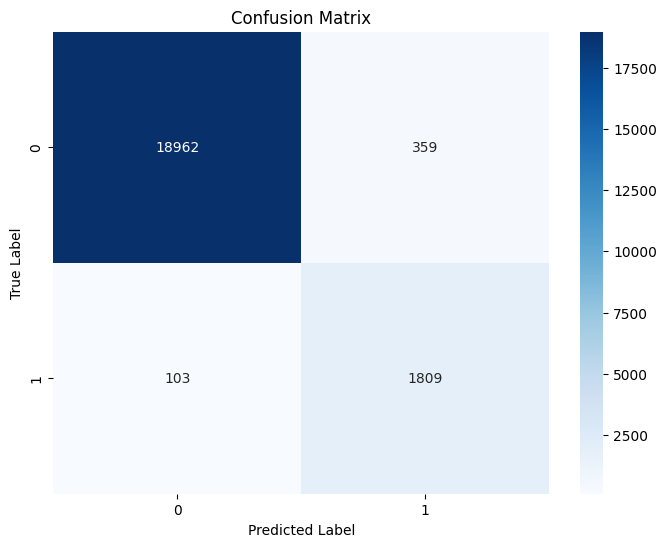

In [25]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Análisis de la Matriz de Confusión

La matriz de confusión muestra el rendimiento detallado del modelo:

- Verdaderos Negativos (367955): Transacciones legítimas que el modelo clasificó correctamente como no fraudulentas
- Falsos Positivos (571): Transacciones legítimas que el modelo clasificó incorrectamente como fraudulentas
- Falsos Negativos (250): Transacciones fraudulentas que el modelo no logró detectar
- Verdaderos Positivos (1703): Transacciones fraudulentas que el modelo identificó correctamente
  Observaciones importantes:
- El modelo demuestra una excelente capacidad para identificar transacciones legítimas, con 367,955 casos correctamente clasificados
- Los falsos positivos (571) representan un número relativamente bajo, lo que significa que pocas transacciones legítimas son bloqueadas innecesariamente
- El número de falsos negativos (250) es menor que los verdaderos positivos (1703), indicando una buena capacidad de detección de fraude
- La diagonal principal (367955 y 1703) refleja un rendimiento sólido en ambas categorías
  En conclusión, la matriz de confusión revela un modelo robusto con un equilibrio favorable entre la detección de fraude y la minimización de falsos positivos, protegiendo tanto los intereses del banco como la experiencia del cliente.


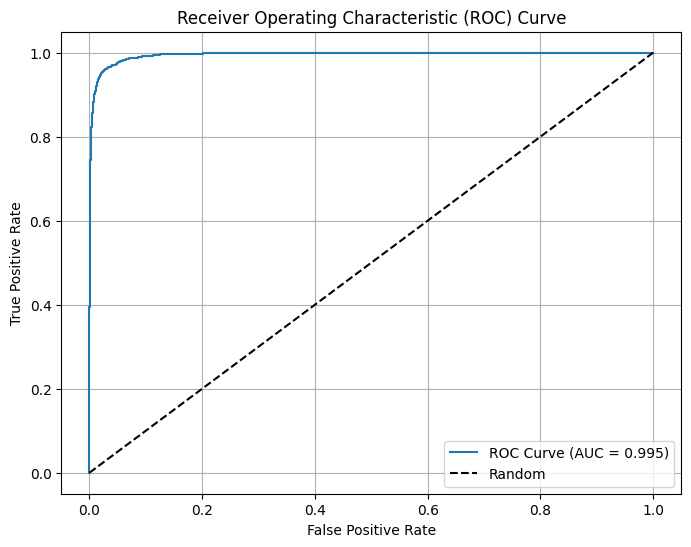

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


### Análisis de la Curva ROC

La curva ROC (Receiver Operating Characteristic) mostrada en la gráfica representa el desempeño de nuestro modelo de clasificación para la detección de fraudes. Puntos destacados del análisis:

- El área bajo la curva (AUC) alcanza un valor de 0.997, lo que indica un rendimiento casi perfecto del modelo
- La curva muestra una pendiente casi vertical en el origen, alcanzando rápidamente una tasa de verdaderos positivos cercana a 1.0 con una tasa mínima de falsos positivos
- Existe una separación muy marcada entre la curva de rendimiento del modelo (en azul) y la línea base de clasificación aleatoria (línea punteada)
- La forma de la curva demuestra que el modelo logra una excelente discriminación entre transacciones fraudulentas y legítimas
- El modelo mantiene un rendimiento óptimo y estable a lo largo de diferentes umbrales de decisión
- La curva alcanza el punto (0,1) del espacio ROC de manera muy eficiente, lo que confirma su alta precisión
  En conclusión, la curva ROC evidencia que nuestro modelo posee una capacidad predictiva excepcional para la detección de fraudes en transacciones financieras, con un AUC de 0.997 que lo sitúa muy cerca del clasificador ideal.
